In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

# Data Engineering

In [1]:
import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from functions import PrepareMacro

C:\Users\marsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###################
# Connect to WRDS #
###################

db = wrds.Connection(yautoconnect=True )

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Linking IBES and CRSP

### 1) Create IBES CRSP Linking table

In [3]:
# 1.1 IBES: Get the list of IBES Tickers for US firms in IBES
_ibes1 = db.raw_sql("""
                        select ticker, cusip, cname, sdates
                        from ibes.id
                        where usfirm='1' 
                        and cusip != ''
                        """, date_cols=['sdates'])

In [4]:
# Create first and last 'start dates' for a given cusip

_ibes1_date = _ibes1.groupby(['ticker','cusip']).sdates.agg(['min', 'max'])\
.reset_index().rename(columns={'min':'fdate', 'max':'ldate'})

_ibes2 = pd.merge(_ibes1, _ibes1_date,how='left', on =['ticker','cusip'])
_ibes2 = _ibes2.sort_values(by=['ticker','cusip','sdates'])

# keep only the most recent company name
_ibes2 = _ibes2.loc[_ibes2.sdates == _ibes2.ldate].drop(['sdates'], axis=1)
_ibes2.head()

,ticker,cusip,cname,fdate,ldate
1,0000,87482X10,TALMER BANCORP,2014-02-20,2014-03-20
6,0001,26878510,EP ENGR CORP,2014-02-20,2019-10-17
7,0004,02504D10,AMERICAN CAPITAL,2014-02-20,2014-02-20
8,000R,14163310,CARECOM,2014-02-20,2014-02-20
9,000V,15117E10,CELLADON,2014-03-20,2014-03-20


In [5]:
# 1.2 CRSP: Get all permno-ncusip combinations
_crsp1 = db.raw_sql("""
                      select permno, ncusip, comnam, namedt, nameenddt
                      from crsp.stocknames where ncusip != ''
                      """, date_cols=['namedt', 'nameenddt'])

In [6]:
_crsp1

,permno,ncusip,comnam,namedt,nameenddt
0,10000,68391610,OPTIMUM MANUFACTURING INC,1986-01-07,1987-06-11
1,10001,39040610,GREAT FALLS GAS CO,1986-01-09,1993-11-21
2,10001,29274A10,ENERGY WEST INC,1993-11-22,2008-02-04
3,10001,29274A20,ENERGY WEST INC,2008-02-05,2009-08-03
4,10001,29269V10,ENERGY INC,2009-08-04,2009-12-17
...,...,...,...,...,...
75341,93433,92870X30,VOLTARI CORP,2013-04-24,2016-12-22
75342,93434,78513510,S & W SEED CO,2010-06-14,2023-12-29
75343,93435,82936G20,SINO CLEAN ENERGY INC,2010-06-14,2012-05-18
75344,93436,88160R10,TESLA MOTORS INC,2010-06-29,2017-02-01


In [7]:
_crsp1_fnamedt = _crsp1.groupby(['permno','ncusip']).namedt.min().reset_index()

_crsp1_lnameenddt = _crsp1.groupby(['permno','ncusip']).nameenddt.max().reset_index()

# merge 
_crsp1_dtrange = pd.merge(_crsp1_fnamedt, _crsp1_lnameenddt, \
                          on = ['permno','ncusip'], how='inner')

_crsp1 = _crsp1.drop(['namedt'],axis=1).rename(columns={'nameenddt':'enddt'})
_crsp2 = pd.merge(_crsp1, _crsp1_dtrange, on =['permno','ncusip'], how='inner')

# keep only most recent company name
_crsp2 = _crsp2.loc[_crsp2.enddt ==_crsp2.nameenddt].drop(['enddt'], axis=1)

In [8]:
# 1.3 Create CUSIP Link Table

_link1_1 = pd.merge(_ibes2, _crsp2, how='inner', left_on='cusip', right_on='ncusip')\
.sort_values(['ticker','permno','ldate'])

_link1_1_tmp = _link1_1.groupby(['ticker','permno']).ldate.max().reset_index()
_link1_2 = pd.merge(_link1_1, _link1_1_tmp, how='inner', on =['ticker', 'permno', 'ldate'])


In [9]:
_link1_2

,ticker,cusip,cname,fdate,ldate,permno,ncusip,comnam,namedt,nameenddt
0,0000,87482X10,TALMER BANCORP,2014-02-20,2014-03-20,14471,87482X10,TALMER BANCORP INC,2014-02-12,2016-08-31
1,0001,26878510,EP ENGR CORP,2014-02-20,2019-10-17,14392,26878510,E P ENERGY CORP,2014-01-17,2019-05-22
2,0004,02504D10,AMERICAN CAPITAL,2014-02-20,2014-02-20,14418,02504D10,AMERICAN CAPITAL SR FLOATING LTD,2014-01-16,2018-08-24
3,000R,14163310,CARECOM,2014-02-20,2014-02-20,14378,14163310,CARE COM INC,2014-01-24,2020-02-10
4,000V,28249U10,EIGER,2016-04-14,2016-04-14,14423,28249U10,EIGER BIOPHARMACEUTICALS INC,2016-03-23,2023-12-29
...,...,...,...,...,...,...,...,...,...,...
21435,ZXIS,98876010,Z-AXIS,2004-06-17,2004-10-14,83970,98876010,Z AXIS CORP,1983-10-26,1985-11-01
21436,ZXZX,16951E10,CHINA ZENIX,2011-07-14,2018-07-19,12720,16951E10,CHINA ZENIX AUTO INTL LTD,2011-05-12,2018-06-13
21437,ZY,87254010,TJX,1989-07-20,2016-06-16,40539,87254010,T J X COMPANIES INC NEW,1989-06-21,2023-12-29
21438,ZYNE,98986X10,ZYNERBA PHARMS,2015-09-17,2015-09-17,15646,98986X10,ZYNERBA PHARMACEUTICALS INC,2015-08-05,2023-10-10


In [10]:
link_table = _link1_2[['permno', 'ncusip']]

### 2) Use Linking Table on IBES and CRSP files

In [11]:
IBES = pd.read_csv('data/ibes_summary.csv')
#IBES_actual = pd.read_csv('data/ibes_actual.csv')

CRSP = pd.read_csv('data/crsp.csv')

C:\Users\marsu\AppData\Local\Temp\ipykernel_15784\2176748675.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  CRSP = pd.read_csv('data/crsp.csv')


In [13]:
CRSP['rankdate']=pd.to_datetime(CRSP.date)
CRSP['date']=pd.to_datetime(CRSP.date)
CRSP['rankdate'] = CRSP['rankdate'].dt.to_period('M')
CRSP['ret'] = pd.to_numeric(CRSP['ret'], errors='coerce')
CRSP = CRSP.sort_values(by=['permno','rankdate'], ascending=True)
CRSP.head()

,Unnamed: 0,permno,cusip,date,cfacshr,price,shrcd,exchcd,ret,rankdate
371,371,10000,68391610,1986-01-07,1.0,2.5625,10,3,NaN,1986-01
372,372,10000,68391610,1986-01-08,1.0,2.5000,10,3,-0.02439,1986-01
373,373,10000,68391610,1986-01-09,1.0,2.5000,10,3,0.00000,1986-01
374,374,10000,68391610,1986-01-10,1.0,2.5000,10,3,0.00000,1986-01
375,375,10000,68391610,1986-01-13,1.0,2.6250,10,3,0.05000,1986-01


In [14]:
IBES.rename(columns= {'anndats_act':'announcement_actual_eps'}, inplace=True)
A = IBES[(IBES.ticker=='AAPL') & (IBES.fpi==6) ]

IBES_actual.rename(columns= {'anndats':'announcement_actual_eps'}, inplace=True)
IBES_actual.head()

IBES_actual = IBES_actual.dropna(subset=['ticker', 'value'], how='any').sort_values(by=['ticker', 'pends'], ascending=True)
IBES_actual[(IBES_actual.ticker=='ZYNX')].head(20)

#match IBES actual file (actual realized earnings) with summary file (analysts' consensus forecasts) using Ticker and fiscal end date (FPEDATS in summary and PENDS in actual)
IBES = pd.merge(IBES_actual, IBES_summary, how='inner', left_on=['ticker', 'pends'], right_on=['ticker', 'fpedats']).drop('pends', axis=1)
IBES.rename(columns={"value": "actual"}, inplace=True)
IBES = IBES[['ticker', 'fpedats', 'actual','announcement_actual_eps', 'cusip', 'cname', 'statpers', 'meanest', 'fpi', 'numest']]
IBES[(IBES.ticker=='ZYNX') & (IBES.fpi==2)].head(20)

In [15]:
IBES_link = pd.merge(IBES, link_table, how='inner', left_on=['cusip'], right_on=['ncusip']).drop('ncusip', axis=1)
IBES_link.head()

,Unnamed: 0,ticker,cusip,cname,fpedats,statpers,meanest,fpi,numest,actual,announcement_actual_eps,permno
0,0,0000,87482X10,TALMER BANCORP,2014-03-31,2014-04-17,0.08,6,4.0,0.12,2014-05-06,14471
1,1,0000,87482X10,TALMER BANCORP,2014-06-30,2014-05-15,0.13,6,5.0,0.27,2014-08-06,14471
2,2,0000,87482X10,TALMER BANCORP,2014-06-30,2014-06-19,0.13,6,5.0,0.27,2014-08-06,14471
3,3,0000,87482X10,TALMER BANCORP,2014-06-30,2014-07-17,0.13,6,5.0,0.27,2014-08-06,14471
4,4,0000,87482X10,TALMER BANCORP,2014-06-30,2014-04-17,0.12,7,5.0,0.27,2014-08-06,14471


In [16]:
IBES_link['statpers'] = pd.to_datetime(IBES_link.statpers)
IBES_link['rankdate'] = pd.to_datetime(IBES_link.statpers).dt.to_period('M')
IBES_link['permno'] = IBES_link['permno'].astype('int')
IBES_link.head()

,Unnamed: 0,ticker,cusip,cname,fpedats,statpers,meanest,fpi,numest,actual,announcement_actual_eps,permno,rankdate
0,0,0000,87482X10,TALMER BANCORP,2014-03-31,2014-04-17,0.08,6,4.0,0.12,2014-05-06,14471,2014-04
1,1,0000,87482X10,TALMER BANCORP,2014-06-30,2014-05-15,0.13,6,5.0,0.27,2014-08-06,14471,2014-05
2,2,0000,87482X10,TALMER BANCORP,2014-06-30,2014-06-19,0.13,6,5.0,0.27,2014-08-06,14471,2014-06
3,3,0000,87482X10,TALMER BANCORP,2014-06-30,2014-07-17,0.13,6,5.0,0.27,2014-08-06,14471,2014-07
4,4,0000,87482X10,TALMER BANCORP,2014-06-30,2014-04-17,0.12,7,5.0,0.27,2014-08-06,14471,2014-04


In [17]:
IBES_CRSP1 = pd.merge(CRSP[['permno', 'price', 'ret', 'cfacshr', 'date']], IBES_link, how='inner',  left_on=['permno', 'date'], right_on=['permno', 'statpers'])
IBES_CRSP1.rename(columns={'cfacshr':'cfacshr_estdate'}, inplace=True)
IBES_CRSP1.drop(['date'], axis=1, inplace=True)
IBES_CRSP1.head()

,permno,price,ret,cfacshr_estdate,Unnamed: 0,ticker,cusip,cname,fpedats,statpers,meanest,fpi,numest,actual,announcement_actual_eps,rankdate
0,10001,10.76,0.002796,1.0,32688,GFGC,36720410,GAS NATURAL INC,2010-12-31,2011-01-20,1.05,1,1.0,0.92,2011-04-05,2011-01
1,10001,10.76,0.002796,1.0,32691,GFGC,36720410,GAS NATURAL INC,2010-12-31,2011-01-20,0.36,6,1.0,0.24,2011-04-05,2011-01
2,10001,10.76,0.002796,1.0,32696,GFGC,36720410,GAS NATURAL INC,2011-03-31,2011-01-20,0.47,7,1.0,0.52,2011-05-11,2011-01
3,10001,10.76,0.002796,1.0,32703,GFGC,36720410,GAS NATURAL INC,2011-06-30,2011-01-20,0.03,8,1.0,0.04,2011-08-12,2011-01
4,10001,10.76,0.002796,1.0,32725,GFGC,36720410,GAS NATURAL INC,2011-12-31,2011-01-20,0.73,2,1.0,0.58,2012-04-10,2011-01


In [18]:
len(IBES_CRSP1)

5769982

In [19]:
# create past Cfacshr
IBES_CRSP1['announcement_actual_eps'] = pd.to_datetime(IBES_CRSP1.announcement_actual_eps)
IBES_CRSP2 = pd.merge(CRSP[['permno', 'cfacshr', 'date']], IBES_CRSP1, how='inner',  left_on=['permno', 'date'], right_on=['permno', 'announcement_actual_eps'])
IBES_CRSP2.rename(columns={'cfacshr':'cfacshr_reportdate'}, inplace=True)
IBES_CRSP2.drop(['date'], axis=1, inplace=True)

IBES_CRSP2.head()

,permno,cfacshr_reportdate,price,ret,cfacshr_estdate,Unnamed: 0,ticker,cusip,cname,fpedats,statpers,meanest,fpi,numest,actual,announcement_actual_eps,rankdate
0,10001,1.0,10.76,0.002796,1.0,32688,GFGC,36720410,GAS NATURAL INC,2010-12-31,2011-01-20,1.05,1,1.0,0.92,2011-04-05,2011-01
1,10001,1.0,10.76,0.002796,1.0,32691,GFGC,36720410,GAS NATURAL INC,2010-12-31,2011-01-20,0.36,6,1.0,0.24,2011-04-05,2011-01
2,10001,1.0,10.92,0.004600,1.0,32689,GFGC,36720410,GAS NATURAL INC,2010-12-31,2011-02-17,1.05,1,1.0,0.92,2011-04-05,2011-02
3,10001,1.0,10.92,0.004600,1.0,32692,GFGC,36720410,GAS NATURAL INC,2010-12-31,2011-02-17,0.36,6,1.0,0.24,2011-04-05,2011-02
4,10001,1.0,11.10,0.013699,1.0,32690,GFGC,36720410,GAS NATURAL INC,2010-12-31,2011-03-17,1.05,1,1.0,0.92,2011-04-05,2011-03


In [20]:
len(IBES_CRSP2)

5110945

In [21]:
IBES_CRSP2['adjust_factor'] = IBES_CRSP2.cfacshr_estdate / IBES_CRSP2.cfacshr_reportdate
IBES_CRSP2['adj_actual'] = IBES_CRSP2.actual  * IBES_CRSP2.adjust_factor
IBES_CRSP2.drop(['actual', 'cfacshr_estdate', 'cfacshr_reportdate' ], axis=1, inplace=True)

In [25]:
IBES_adj_actual.head()

,announcement_actual_eps,ticker,adj_actual
552588,2014-05-06,0000,0.12
552589,2014-08-06,0000,0.27
552590,2014-08-06,0000,0.27
552591,2014-08-06,0000,0.27
552592,2014-08-06,0000,0.27


### Past EPS

In [22]:
def group_fpi(fpi):
    if fpi in [6, 7, 8]:
        return '678'
    elif fpi in [1, 2]:
        return '12'
    return fpi

In [58]:
# create past_eps: add actual of 'announcement_actual_eps' closer and before statpers
IBES_CRSP2 = IBES_CRSP2.sort_values(by=['ticker','statpers'], ascending=True)

IBES_adj_actual = IBES_CRSP2[['announcement_actual_eps','ticker', 'adj_actual','fpi']].sort_values(by=['ticker','announcement_actual_eps'], ascending=True)
IBES_adj_actual.dropna(subset=['announcement_actual_eps'], inplace=True)
IBES_adj_actual['announcement_actual_eps'] = pd.to_datetime(IBES_adj_actual.announcement_actual_eps)

# Perform the merge using the new fpi_group column
IBES_CRSP2['fpi_group'] = IBES_CRSP2['fpi'].apply(group_fpi)
IBES_adj_actual['fpi_group'] = IBES_adj_actual['fpi'].apply(group_fpi)

IBES_CRSP = pd.merge_asof(
    IBES_CRSP2.set_index('statpers').sort_index(),
    IBES_adj_actual.set_index('announcement_actual_eps', drop=False).sort_index(),
    left_index=True,
    right_index=True,
    by=['ticker', 'fpi_group'],
    direction='backward'
)

#IBES_CRSP.drop(['fpedats_y'], axis=1, inplace=True)                    
IBES_CRSP.rename(columns={'adj_actual_x':'adj_actual', 'adj_actual_y':'adj_past_eps', 'announcement_actual_eps_x':'announcement_actual_eps', 'announcement_actual_eps_y': 'announcement_past_ep','fpi_x' : 'fpi' }, inplace=True)
IBES_CRSP = IBES_CRSP.drop(columns=['fpi_group','fpi_y'])
IBES_CRSP = IBES_CRSP.reset_index()
IBES_CRSP.tail()

,statpers,permno,price,ret,Unnamed: 0,ticker,cusip,cname,fpedats,meanest,fpi,numest,announcement_actual_eps,rankdate,adjust_factor,adj_actual,announcement_past_ep,adj_past_eps
5110940,2023-12-14,16883,0.2842,0.052593,238492,CSSE,16842Q10,CHICKEN SOUP,2023-09-30,-1.17,6,5.0,2023-12-22,2023-12,1.0,-1.86,2023-08-14,-1.50
5110941,2023-12-14,77699,1.5600,0.114286,432883,ERC1,35952H60,FUELCELL ENERGY,2023-10-31,-0.08,6,9.0,2023-12-19,2023-12,1.0,-0.07,2023-09-11,-0.06
5110942,2023-12-14,21513,1.0500,0.019418,106728,ALZN,02262M40,ALZAMEND NEURO,2023-10-31,-0.68,6,2.0,2023-12-15,2023-12,1.0,-0.44,NaT,NaN
5110943,2023-12-14,83601,56.4000,0.030890,372848,WTHG,98181110,WORTHINGTON ENTP,2023-11-30,0.71,6,2.0,2023-12-19,2023-12,1.0,0.78,2023-09-27,2.06
5110944,2023-12-14,93397,19.0300,0.007411,374780,LMNR,53274610,LIMONEIRA,2023-10-31,-0.47,1,2.0,2023-12-21,2023-12,1.0,-0.43,2022-12-22,-0.04


In [65]:
fpi_value = 8

count_fpi_1 = (IBES_adj_actual['fpi'] == fpi_value).sum()
count_fpi_2 = (IBES_CRSP['fpi'] == fpi_value).sum()
print(count_fpi_1,count_fpi_2,(count_fpi_2/count_fpi_1-1)*100)

923483 923483 0.0


In [55]:
IBES_CRSP2.head()

,permno,price,ret,Unnamed: 0,ticker,cusip,cname,fpedats,statpers,meanest,fpi,numest,announcement_actual_eps,rankdate,adjust_factor,adj_actual,fpi_group
552588,14471,13.77,0.001455,0,0000,87482X10,TALMER BANCORP,2014-03-31,2014-04-17,0.08,6,4.0,2014-05-06,2014-04,1.0,0.12,678
552589,14471,13.77,0.001455,4,0000,87482X10,TALMER BANCORP,2014-06-30,2014-04-17,0.12,7,5.0,2014-08-06,2014-04,1.0,0.27,678
552593,14471,13.77,0.001455,11,0000,87482X10,TALMER BANCORP,2014-09-30,2014-04-17,0.15,8,5.0,2014-11-04,2014-04,1.0,0.26,678
552600,14471,13.77,0.001455,12,0000,87482X10,TALMER BANCORP,2014-12-31,2014-04-17,0.52,1,4.0,2015-01-30,2014-04,1.0,1.21,12
552646,14471,13.77,0.001455,70,0000,87482X10,TALMER BANCORP,2015-12-31,2014-04-17,0.85,2,5.0,2016-01-26,2014-04,1.0,1.02,12


In [66]:
A = IBES_CRSP[(IBES_CRSP.ticker == 'AAPL') & (IBES_CRSP.fpi==1)][['adj_actual', 'fpedats','adj_past_eps']]

In [67]:
len(IBES_CRSP)

5110945

(-10.0, 10.0)

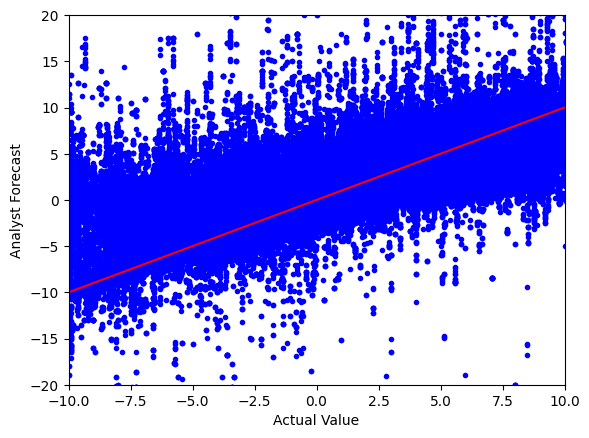

In [68]:
# plot forecast and exact 
plt.plot(IBES_CRSP.adj_actual, IBES_CRSP.meanest, '.', color='blue')
plt.plot([-10,10], [-10,10], 'r-')
plt.xlabel('Actual Value')
plt.ylabel('Analyst Forecast')
plt.xlim(-10,10)
plt.ylim(-10,10)


(-20.0, 20.0)

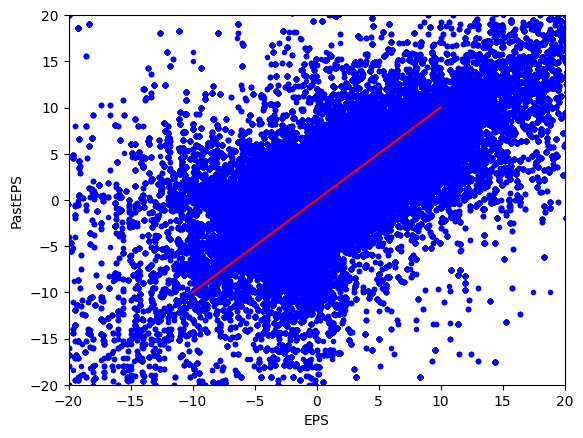

In [69]:
# plot eps and past eps 
plt.plot(IBES_CRSP.adj_past_eps, IBES_CRSP.adj_actual, '.', color='blue')
plt.plot([-10,10], [-10,10], 'r-')
plt.xlabel('EPS')
plt.ylabel('PastEPS')
plt.xlim(-20,20)
plt.ylim(-20,20)

In [70]:
IBES_CRSP.to_csv('data/ibes_crsp.csv')

## Macroeconomic Data

In [71]:
GDP_Raw = pd.read_csv('data/real_GDP_FED.csv', index_col=0)
IPT_Raw = pd.read_csv('data/IPT_FED.csv', skiprows=range(1, 620), index_col=0)
IPT_Raw.drop(IPT_Raw.columns[1:121], axis=1, inplace=True)
IPT_Raw.reset_index(inplace=True, drop=True)
Cons_Raw = pd.read_csv('data/real_personal_consumption_FED.csv', index_col=0)
Unempl_Raw = pd.read_csv('data/Unemployment_FED.csv',skiprows=range(1, 225), index_col=0)

In [72]:
IPT_Raw

,DATE,IPT72M11,IPT72M12,IPT73M1,IPT73M2,IPT73M3,IPT73M4,IPT73M5,IPT73M6,IPT73M7,...,IPT23M7,IPT23M8,IPT23M9,IPT23M10,IPT23M11,IPT23M12,IPT24M1,IPT24M2,IPT24M3,IPT24M4
0,1970:08,107.5,107.5,107.5,107.5,107.5,107.5,107.5,107.5,107.5,...,37.6,37.6,37.6,37.6,37.6,37.6,37.6,37.6,37.6,37.6
1,1970:09,106.3,106.3,106.3,106.3,106.3,106.3,106.3,106.3,106.3,...,37.4,37.4,37.4,37.4,37.4,37.4,37.4,37.4,37.4,37.4
2,1970:10,103.7,103.7,103.7,103.7,103.7,103.7,103.7,103.7,103.7,...,36.6,36.6,36.6,36.6,36.6,36.6,36.6,36.6,36.6,36.6
3,1970:11,102.8,102.8,102.8,102.8,102.8,102.8,102.8,102.8,102.8,...,36.4,36.4,36.4,36.4,36.4,36.4,36.4,36.4,36.4,36.4
4,1970:12,104.9,104.9,104.9,104.9,104.9,104.9,104.9,104.9,104.9,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,2023:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,102.7,102.4,102.7,103.0,102.9
640,2023:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,102.5,102.7,102.7,102.6
641,2024:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.6,102.2,101.8
642,2024:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.3,102.3


In [73]:
GDP_Data = PrepareMacro(GDP_Raw,65,11,'ROUTPUT','GDP');
IPT_Data = PrepareMacro(IPT_Raw,72,11,'IPT','IPT');
Cons_Data = PrepareMacro(Cons_Raw,65,11,'RCON','Cons');

c:\Users\marsu\Man-vs-machine\functions.py:35: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  B = pd.value_counts(A.isna().values)
c:\Users\marsu\Man-vs-machine\functions.py:35: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  B = pd.value_counts(A.isna().values)
c:\Users\marsu\Man-vs-machine\functions.py:35: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  B = pd.value_counts(A.isna().values)


In [74]:
IPT_Data

,Dates,IPT
0,1972-11-01,116.7
1,1972-12-01,118.5
2,1973-01-01,119.3
3,1973-02-01,119.8
4,1973-03-01,120.8
...,...,...
613,2023-12-01,36.4
614,2024-01-01,36.6
615,2024-02-01,37.4
616,2024-03-01,37.6


In [75]:
#Different method for unemployemnt because data organised differently
Unempl_Arr = Unempl_Raw.to_numpy()
shape = Unempl_Arr.shape
N = shape[0]
values = []
for i in range(0,N):
    x = Unempl_Arr[i,1:]
    first_non_nan_value = next((value for value in x if not np.isnan(value)), None)
    values.append(first_non_nan_value)

#DataFrame
d = {'Dates':Unempl_Raw['DATE'], 'Unempl':values}
Unempl_Data = pd.DataFrame(data=d)
Unempl_Data['Dates'] = Unempl_Data['Dates'].str.replace(':', '-')
Unempl_Data['Dates'] = pd.to_datetime(Unempl_Data['Dates'], format='%Y-%m')


In [ ]:
Unempl_Data

### Log of the differences (not for unemployment rate)

In [76]:
dfs_difference = [GDP_Data, Cons_Data, IPT_Data ]
cols_difference = ['GDP', 'Cons', 'IPT' ]
count = 0
for df, name in zip(dfs_difference, cols_difference):
    column_name = name + '_' + 'log_return'
    df[column_name] = np.log(df[name] / df[name].shift(1))
    df.dropna(inplace=True)


### Merge

In [77]:
merged_macro = Unempl_Data
for file in dfs_difference:
    merged_macro = pd.merge(merged_macro,file, on = ['Dates'], how = 'outer')

merged_macro.to_csv('data/processed_data/macro_data.csv')
merged_macro.head()

,Dates,Unempl,GDP,GDP_log_return,Cons,Cons_log_return,IPT,IPT_log_return
0,1965-09-01,4.4,NaN,NaN,NaN,NaN,NaN,NaN
1,1965-10-01,4.3,NaN,NaN,NaN,NaN,NaN,NaN
2,1965-11-01,4.2,NaN,NaN,NaN,NaN,NaN,NaN
3,1965-12-01,4.1,609.7,0.000985,396.7,0.016521,NaN,NaN
4,1966-01-01,4.0,609.7,0.000000,396.7,0.000000,NaN,NaN


## Financial Ratio

In [78]:
finratio = pd.read_csv('data/finratio.csv', index_col=0)
finratio.head()

C:\Users\marsu\AppData\Local\Temp\ipykernel_15784\1677955836.py:1: DtypeWarning: Columns (100) have mixed types. Specify dtype option on import or set low_memory=False.
  finratio = pd.read_csv('data/finratio.csv', index_col=0)


,gvkey,permno,adate,qdate,public_date,capei,be,bm,evm,pe_op_basic,...,ffi30_desc,ffi30,ffi38_desc,ffi38,ffi48_desc,ffi48,ffi49_desc,ffi49,ticker,cusip
0,1001,10015,1983-12-31,1984-09-30,1985-01-31,NaN,9.105,0.551751,7.158486,NaN,...,MEALS,28.0,RTAIL,34.0,MEALS,43.0,MEALS,44.0,AMFD,00016510
1,1001,10015,1984-12-31,1984-12-31,1985-02-28,NaN,9.319,0.696487,5.660224,NaN,...,MEALS,28.0,RTAIL,34.0,MEALS,43.0,MEALS,44.0,AMFD,00016510
2,1001,10015,1984-12-31,1984-12-31,1985-03-31,NaN,9.319,0.696487,5.660224,NaN,...,MEALS,28.0,RTAIL,34.0,MEALS,43.0,MEALS,44.0,AMFD,00016510
3,1001,10015,1984-12-31,1984-12-31,1985-04-30,NaN,9.319,0.696487,5.660224,NaN,...,MEALS,28.0,RTAIL,34.0,MEALS,43.0,MEALS,44.0,AMFD,00016510
4,1001,10015,1984-12-31,1985-03-31,1985-05-31,NaN,9.630,0.491414,6.339642,NaN,...,MEALS,28.0,RTAIL,34.0,MEALS,43.0,MEALS,44.0,AMFD,00016510


In [79]:
print(finratio.columns.tolist())

['gvkey', 'permno', 'adate', 'qdate', 'public_date', 'capei', 'be', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'gprof', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ret_crsp', 'gsector', 'gicdesc', 'mktcap', 'price', 'ptb', 'peg_trailing', 'divyield', 'peg_1yrforward', 'peg_ltgforward', 'ffi5_desc', 'ffi5', 'ff

In [80]:
#We exclude PEG 1yrforward, PEG ltgforward, pe op basic, and pe op dil from our forecast model, because these variables have too many missing observations.
finratio.drop(['peg_1yrforward', 'peg_ltgforward', 'pe_op_basic', 'pe_op_dil', 'price', 'ret_crsp'], axis=1, inplace=True)

In [81]:
finratio['public_date'] = pd.to_datetime(finratio['public_date'].astype('str'))
finratio.drop(['gvkey', 'adate', 'qdate',  'ticker', 'cusip', 'ffi5_desc', 'ffi5', 'ffi10_desc', 'ffi10', 'ffi12_desc', 'ffi12', 'ffi17_desc', 'ffi17',
                'ffi30_desc', 'ffi30', 'ffi38_desc', 'ffi38', 'ffi48_desc', 'ffi48', 'ffi49_desc','gsector', 'gicdesc' ], axis=1, inplace=True)

In [82]:
vars_winsorize = list(finratio.drop(['permno'], axis=1).columns)

In [83]:
finratio = finratio.dropna(axis=0, subset=['ffi49'])

In [84]:
foo = finratio.groupby(['public_date', 'ffi49'])[vars_winsorize]
foo.transform(lambda x: x.median(skipna=True))

,public_date,capei,be,bm,evm,pe_exi,pe_inc,ps,pcf,dpr,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,mktcap,ptb,peg_trailing,divyield,ffi49
0,1985-01-31,15.038979,21.285,0.555475,6.994473,13.85386,13.876262,0.586076,6.434597,0.0,...,16.424335,0.0,0.024333,0.0,-0.053217,40.481875,1.82996,0.455015,0.013529,44.0
1,1985-02-28,14.545138,20.444,0.594367,6.521488,14.447753,14.199309,0.622112,6.932156,0.0,...,17.843082,0.0,0.025503,0.0,-0.059936,39.356375,1.934553,0.642836,0.012262,44.0
2,1985-03-31,14.629596,20.607,0.594367,6.64799,14.612676,13.835878,0.629638,7.755468,0.0,...,19.075643,0.0,0.025503,0.0,-0.050433,40.851687,2.000044,0.633807,0.01194,44.0
3,1985-04-30,15.011877,20.607,0.589748,6.643585,14.529799,13.858469,0.628474,7.387737,0.0,...,20.308204,0.0,0.02557,0.0,-0.05336,38.024,1.864909,0.599096,0.013161,44.0
4,1985-05-31,15.21988,21.7015,0.560496,7.219646,14.351851,14.351851,0.655262,8.252898,0.01931,...,17.09865,0.0,0.025638,0.0,-0.046393,39.253438,1.869384,0.633334,0.012121,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178216,2023-08-31,-1.810486,87.291,0.499776,-2.498343,-1.864662,-1.818681,7.831514,-1.778947,0.0,...,0.338539,0.156199,0.0,0.0,-0.074412,121.588359,1.876339,-0.016968,0.033237,13.0
178217,2023-09-30,-1.666151,87.571,0.498259,-2.498343,-1.660262,-1.62055,6.628697,-1.565724,0.0,...,0.341325,0.151555,0.0,0.0,-0.076076,109.045511,1.623301,-0.017813,0.031701,13.0
178218,2023-10-31,-1.374058,87.571,0.493227,-2.510681,-1.427655,-1.427655,5.985649,-1.285992,0.0,...,0.330874,0.156199,0.0,0.0,-0.074723,96.18815,1.436652,-0.015323,0.035769,13.0
178219,2023-11-30,-1.404206,85.663,0.553856,-2.416221,-1.327273,-1.327273,6.619312,-1.305125,0.0,...,0.311823,0.17395,0.0,0.0,-0.07975,103.773797,1.626128,-0.019033,0.031874,13.0


In [85]:
# Replace NA with the industry median
finratio.loc[:, vars_winsorize] = finratio.groupby(['public_date', 'ffi49'])[vars_winsorize].transform(lambda x: x.fillna(x.median(skipna=True)))
print(finratio[vars_winsorize].isna().sum().sum())

# Replace remaining NA values with last month's value
finratio.loc[:, vars_winsorize] = finratio.groupby('permno')[vars_winsorize].transform(lambda x: x.ffill().bfill())
print(finratio[vars_winsorize].isna().sum().sum())

# Replace any remaining NA with the industry median again
finratio.loc[:, vars_winsorize] = finratio.groupby(['public_date', 'ffi49'])[vars_winsorize].transform(lambda x: x.fillna(x.median(skipna=True)))
print(finratio[vars_winsorize].isna().sum().sum())


1434
0
0


In [86]:
for column in finratio.columns:
    na_count = finratio[column].isna().sum()
    if na_count > 0:
        print(f"{column}: {na_count}")

### Merge FinRatio with IBES_CRSP

In [87]:
# create past_eps_ add atual of anndats_act closer and before statpers
IBES_CRSP = IBES_CRSP.sort_values(by=['permno','statpers'], ascending=True)
IBES_CRSP.statpers = pd.to_datetime(IBES_CRSP.statpers)
finratio = finratio.sort_values(by=['permno','public_date'], ascending=True)

IBES_CRSP.permno = IBES_CRSP.permno.astype(int)
finratio.permno = finratio.permno.astype(int)

data = pd.merge_asof( IBES_CRSP.set_index('statpers').sort_index(),
                    finratio.set_index('public_date',drop=False).sort_index(),
                    left_index=True, 
                    right_index=True,
                    by = 'permno',
                    direction='backward')  

data = data.reset_index()
data.sort_values(by=['permno','rankdate'], ascending=True)
data.tail()

,statpers,permno,price,ret,Unnamed: 0,ticker,cusip,cname,fpedats,meanest,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,mktcap,ptb,peg_trailing,divyield,ffi49
5110940,2023-12-14,61621,126.8300,-0.010069,186895,PAYX,70432610,PAYCHEX,2023-11-30,1.07,...,3.106931,0.0,0.000000,0.343512,-0.038073,43887.489779,11.896530,1.839989,0.029188,34.0
5110941,2023-12-14,21513,1.0500,0.019418,106728,ALZN,02262M40,ALZAMEND NEURO,2023-10-31,-0.68,...,0.311823,0.0,0.000000,0.000000,-0.716338,8.499040,2.790230,-0.019033,0.031874,13.0
5110942,2023-12-14,16883,0.2842,0.052593,238492,CSSE,16842Q10,CHICKEN SOUP,2023-09-30,-1.17,...,5.104916,0.0,0.032435,0.000000,-0.675238,6.713255,0.127277,-0.000095,0.014672,7.0
5110943,2023-12-14,16104,0.4112,0.025436,59373,ONS,69012T20,OUTLOOK,2023-09-30,-0.25,...,0.311823,0.0,0.000000,0.000000,-0.526394,124.923837,1.626128,-0.019033,0.031874,13.0
5110944,2023-12-14,83601,56.4000,0.030890,372848,WTHG,98181110,WORTHINGTON ENTP,2023-11-30,0.71,...,4.746612,0.0,0.006008,0.000000,-0.090000,3582.490348,1.917273,0.060135,0.017852,19.0


In [88]:
print(data.columns.tolist())

['statpers', 'permno', 'price', 'ret', 'Unnamed: 0', 'ticker', 'cusip', 'cname', 'fpedats', 'meanest', 'fpi', 'numest', 'announcement_actual_eps', 'rankdate', 'adjust_factor', 'adj_actual', 'announcement_past_ep', 'adj_past_eps', 'public_date', 'capei', 'be', 'bm', 'evm', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'gprof', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sa

In [89]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
print(data.shape)

(5110945, 88)


## FINAL: DATASETS SEPARTED BY FPI

In [90]:
A1 = data[data.fpi == 1].reset_index(drop=True)
A2= data[data.fpi == 2].reset_index(drop=True)
Q1 = data[data.fpi == 6].reset_index(drop=True)
Q2 = data[data.fpi == 7].reset_index(drop=True)
Q3 = data[data.fpi == 8].reset_index(drop=True)

(-15.0, 15.0)

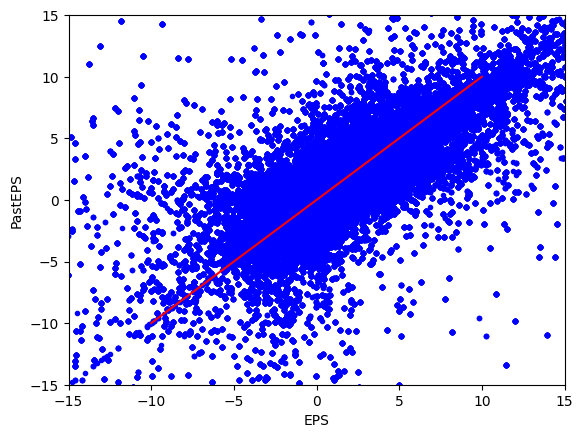

In [92]:
plt.plot(A1.adj_actual, A1.adj_past_eps, '.', color='blue')
plt.plot([-10,10], [-10,10], 'r-')
plt.xlabel('EPS')
plt.ylabel('PastEPS')
plt.xlim(-15,15)
plt.ylim(-15,15)

In [93]:
for Forecast in [A1, A2, Q1, Q2, Q3]:
    df_name = next(name for name, obj in globals().items() if obj is Forecast)
    Forecast.dropna(subset=['adj_actual', 'meanest', 'adj_past_eps'], inplace=True)
    Forecast.sort_values(by=['permno', 'rankdate'], ascending=True, inplace=True)
    Forecast.reset_index(drop=True, inplace=True)
    Forecast.to_csv(f"data/processed_data/{df_name}.csv", index=False)